# Currency Correlation Graphs

This notebook creates correlation graphs between tweet sentiment and currency market movements. It visualizes how social media sentiment correlates with exchange rate changes for major currencies (CAD, INR, JPY, GBP).

The graphs show:
- Smoothed exchange rate daily changes over time
- Tweet mentions plotted as colored dots on the curve
- Sentiment-based color coding: Red=Negative, White=Neutral, Blue=Positive

## 1. Import Required Libraries

Import necessary libraries for data visualization including matplotlib, pandas, numpy, and scipy.

In [52]:
# Import required libraries for visualization and data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


## 2. Load Data

Load the processed tweet dataset and define helper functions for loading exchange rate data.

In [ ]:
df = pd.read_csv('tweets.csv', on_bad_lines='skip')
data_source = 'tweets.csv'

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

print(f"Loaded {len(df)} processed tweets from {data_source}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print("\nColumns available:", list(df.columns))

# Check what currency columns we have and create a unified interface
if 'currencies_found' in df.columns:
    currency_column = 'currencies_found'
    print("✓ Using 'currencies_found' column")
elif 'currency_codes' in df.columns:
    currency_column = 'currency_codes'
    print("✓ Using 'currency_codes' column")
else:
    print("❌ Error: No currency columns found")
    currency_column = None

# Check if we have the required columns for correlation graphs
required_columns = ['date', 'text', 'sentiment_compound']
if currency_column:
    required_columns.append(currency_column)

missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    print(f"⚠️  Warning: Missing columns: {missing_columns}")
    print("Please run the main.ipynb notebook first to generate the processed dataset.")
else:
    print("✓ All required columns are present")

# Show analysis-ready data summary
if currency_column and 'sentiment_compound' in df.columns:
    tweets_with_analysis = df[
        (df[currency_column].notna()) &
        (df[currency_column] != '') &
        (df['sentiment_compound'].notna())
    ]
    print(f"\n📊 Analysis Summary:")
    print(f"  - {len(tweets_with_analysis)} tweets ready for correlation analysis")
    print(f"  - Sentiment range: {df['sentiment_compound'].min():.3f} to {df['sentiment_compound'].max():.3f}")

    # Show target currencies data
    target_currencies = ['CAD', 'INR', 'JPY', 'GBP']
    print(f"\n🎯 Target Currencies for Correlation Graphs:")
    for currency in target_currencies:
        if currency_column == 'currencies_found':
            count = df[currency_column].apply(
                lambda currencies: currencies and currency in currencies if currencies else False
            ).sum()
        else:
            count = df[currency_column].str.contains(currency, na=False, case=False).sum()
        print(f"  - {currency}: {count} mentions")
else:
    print("\n❌ Cannot proceed: Missing required columns for analysis")

Loaded 6896 processed tweets from tweets_reordered.csv (reordered dataset)
Date range: 2024-10-13 04:23:37+00:00 to 2025-10-25 22:15:50+00:00

Columns available: ['id', 'date', 'text', 'image_url', 'countries_found', 'currencies_found', 'sentiment_compound', 'sentiment_positive', 'sentiment_negative', 'sentiment_neutral', 'sentiment_label', 'page_number', 'browse_flag', 'document_id', 'media_type', 'sequence', 'speaker', 'speaker_id', 'subject', 'type', 'word_count', 'deleted_flag', 'account_url', 'handle', 'platform', 'post_url', 'social_author', 'social_favorite_count', 'social_repost_count', 'social_visibility', 'search_id', 'score', 'countries_mentioned', 'currency_codes']
✓ Using 'currencies_found' column
✓ All required columns are present

📊 Analysis Summary:
  - 6896 tweets ready for correlation analysis
  - Sentiment range: -0.998 to 0.997

🎯 Target Currencies for Correlation Graphs:
  - CAD: 55 mentions
  - INR: 26 mentions
  - JPY: 21 mentions
  - GBP: 33 mentions


In [54]:
def load_exchange_rate_data(currency_code):
    """Load exchange rate data for a given currency"""
    try:
        filename = f'exchange_rates/{currency_code}_USD_rates.csv'
        data = pd.read_csv(filename)
        data['Date'] = pd.to_datetime(data['Date'])
        data = data.sort_values('Date')

        # Calculate daily percentage change
        data['Daily_Change_Pct'] = data['Rate'].pct_change() * 100

        return data
    except FileNotFoundError:
        print(f"Exchange rate data not found for {currency_code}")
        return None

print("Exchange rate data loading function defined")

Exchange rate data loading function defined


## 3. Data Validation

Validate the preprocessed data from main.ipynb is ready for correlation graph generation.

In [55]:
# Data is already preprocessed from main.ipynb - just validate and clean if needed
print("Using preprocessed data from main analysis...")

# Remove any rows with missing critical data
initial_count = len(df)
df_clean = df.dropna(subset=['date', 'sentiment_compound'])
removed_count = initial_count - len(df_clean)

if removed_count > 0:
    print(f"Removed {removed_count} rows with missing date/sentiment data")

# Filter for tweets with country mentions (data already processed)
tweets_with_countries = df_clean[df_clean['countries_mentioned'].notna() &
                                (df_clean['countries_mentioned'] != '')].copy()

print(f"✓ Data validation complete")
print(f"  - Total tweets: {len(df_clean)}")
print(f"  - Tweets with country mentions: {len(tweets_with_countries)}")
print(f"  - Sentiment score range: {df_clean['sentiment_compound'].min():.3f} to {df_clean['sentiment_compound'].max():.3f}")

# Show currency analysis data (if available)
if 'currency_codes' in df_clean.columns:
    tweets_with_currencies = df_clean[df_clean['currency_codes'].notna() &
                                     (df_clean['currency_codes'] != '')].copy()
    print(f"  - Tweets with currency mappings: {len(tweets_with_currencies)}")

# Update df to use cleaned data
df = df_clean
print(f"\n🚀 Ready for correlation graph generation with {len(df)} tweets")

Using preprocessed data from main analysis...
✓ Data validation complete
  - Total tweets: 6896
  - Tweets with country mentions: 1949
  - Sentiment score range: -0.998 to 0.997
  - Tweets with currency mappings: 1949

🚀 Ready for correlation graph generation with 6896 tweets


## 4. Create Currency Plot Function

Build the core function for creating individual currency correlation plots with sentiment-colored dots.

In [56]:
def create_currency_plot(currency_code, currency_name, ax):
    """Create a plot for a specific currency with sentiment-colored tweet dots"""

    # Load exchange rate data
    exchange_data = load_exchange_rate_data(currency_code)
    if exchange_data is None:
        ax.text(0.5, 0.5, f'No data available for {currency_code}',
               ha='center', va='center', transform=ax.transAxes)
        return

    # Create lookup dictionary for exchange rates
    change_lookup = {}
    for _, row in exchange_data.iterrows():
        date_str = row['Date'].strftime('%Y-%m-%d')
        change_lookup[date_str] = {
            'change': row['Daily_Change_Pct'],
            'datetime': row['Date']
        }

    # Get tweets mentioning this currency using the currencies_found column
    if currency_column == 'currencies_found':
        # currencies_found is a list format
        currency_tweets = df[df[currency_column].apply(
            lambda currencies: currencies and currency_code in currencies if currencies else False
        )].copy()
    else:
        # currency_codes is a string format
        currency_tweets = df[df[currency_column].str.contains(currency_code, na=False, case=False)].copy()

    if len(currency_tweets) == 0:
        ax.text(0.5, 0.5, f'No tweets found mentioning {currency_code}',
               ha='center', va='center', transform=ax.transAxes)
        return

    # Plot exchange rate changes (smoothed)
    valid_dates = exchange_data['Date']
    changes = exchange_data['Daily_Change_Pct'].fillna(0)
    smoothed_changes = gaussian_filter1d(changes, sigma=2)

    ax.plot(valid_dates, smoothed_changes, 'b-', linewidth=2,
           label=f'{currency_code}-USD Daily Change % (Smoothed)', alpha=0.8)

    # Collect tweet dates and sentiment data, placing dots on the smoothed curve
    valid_tweet_dates = []
    tweet_curve_values = []
    valid_sentiments = []
    valid_tweet_data = []  # Store complete tweet data for labeling

    # Get smoothed curve data
    curve_dates = valid_dates
    curve_values = smoothed_changes

    # Create interpolation function to get curve values at any date
    if len(curve_dates) > 1:
        # Convert dates to numerical values for interpolation
        curve_dates_num = np.array([(d - curve_dates.iloc[0]).days for d in curve_dates])
        curve_interp = interp1d(curve_dates_num, curve_values, kind='linear',
                               bounds_error=False, fill_value='extrapolate')

        for idx, tweet in currency_tweets.iterrows():
            tweet_date = pd.to_datetime(tweet['date'])
            tweet_date_str = tweet_date.strftime('%Y-%m-%d')

            if tweet_date_str in change_lookup and not pd.isna(change_lookup[tweet_date_str]['change']):
                # Calculate days from start for interpolation
                days_from_start = (tweet_date - curve_dates.iloc[0]).days

                # Get the y-value on the smoothed curve at this date
                curve_y_value = curve_interp(days_from_start)

                valid_tweet_dates.append(change_lookup[tweet_date_str]['datetime'])
                tweet_curve_values.append(curve_y_value)
                valid_sentiments.append(tweet['sentiment_compound'])
                valid_tweet_data.append({
                    'id': tweet['id'] if 'id' in tweet else idx,  # Use actual tweet ID if available
                    'index': idx,
                    'date': change_lookup[tweet_date_str]['datetime'],
                    'curve_value': curve_y_value,
                    'sentiment': tweet['sentiment_compound'],
                    'text': tweet['text'][:50] + '...' if len(tweet['text']) > 50 else tweet['text']
                })

    # Create sentiment-based colors
    if valid_sentiments:
        colors = []
        for sentiment in valid_sentiments:
            if sentiment < -0.05:  # Negative sentiment
                # Red intensity based on how negative (-1 = full red, -0.05 = light red)
                intensity = abs(sentiment) / 1.0  # Normalize to 0-1
                colors.append((1.0, 1.0 - intensity * 0.8, 1.0 - intensity * 0.8))  # Red to pink
            elif sentiment > 0.05:  # Positive sentiment
                # Blue intensity based on how positive (1 = full blue, 0.05 = light blue)
                intensity = sentiment / 1.0  # Normalize to 0-1
                colors.append((1.0 - intensity * 0.8, 1.0 - intensity * 0.8, 1.0))  # Blue to light blue
            else:  # Neutral sentiment (-0.05 to 0.05)
                colors.append((1.0, 1.0, 1.0))  # White

        # Plot tweet mentions with sentiment colors on the curve
        ax.scatter(valid_tweet_dates, tweet_curve_values,
                  c=colors, s=60, alpha=0.9, zorder=5, edgecolors='black', linewidth=0.8,
                  label=f'{currency_code} Mentioned ({len(valid_tweet_dates)})')

        # Find and highlight the most positive and most negative tweets
        extreme_tweet_info = ""
        if len(valid_tweet_data) > 0:
            # Find most positive and most negative tweets
            sentiments = [tweet['sentiment'] for tweet in valid_tweet_data]
            most_positive_idx = np.argmax(sentiments)
            most_negative_idx = np.argmin(sentiments)

            # Add bold outline to most positive tweet dot
            if sentiments[most_positive_idx] > 0.05:  # Only highlight if actually positive
                pos_tweet = valid_tweet_data[most_positive_idx]
                ax.scatter([pos_tweet['date']], [pos_tweet['curve_value']],
                          s=80, facecolors='none', edgecolors='blue', linewidth=4, zorder=10)
                extreme_tweet_info += f"Pos(Score:{pos_tweet['sentiment']:.2f}): {pos_tweet['id']}  "

            # Add bold outline to most negative tweet dot
            if sentiments[most_negative_idx] < -0.05:  # Only highlight if actually negative
                neg_tweet = valid_tweet_data[most_negative_idx]
                ax.scatter([neg_tweet['date']], [neg_tweet['curve_value']],
                          s=80, facecolors='none', edgecolors='red', linewidth=4, zorder=10)
                extreme_tweet_info += f"Neg(Score:{neg_tweet['sentiment']:.2f}): {neg_tweet['id']}"
        # Add tweet ID information below the plot
        if extreme_tweet_info:
            ax.text(0.02, -0.08, extreme_tweet_info.strip(), transform=ax.transAxes,
                   fontsize=7, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.2',
                   facecolor='lightgray', alpha=0.8))
    ax.set_title(f'{currency_code} Exchange Rate vs Tweet Sentiment', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Daily Change %')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)

print("Currency plot function defined")

Currency plot function defined


## 5. Build 4-Currency Correlation Visualization

Create the main correlation visualization showing all four major currencies (CAD, INR, JPY, GBP) in a 2x2 subplot layout.

Building correlation graphs for 4 major currencies...


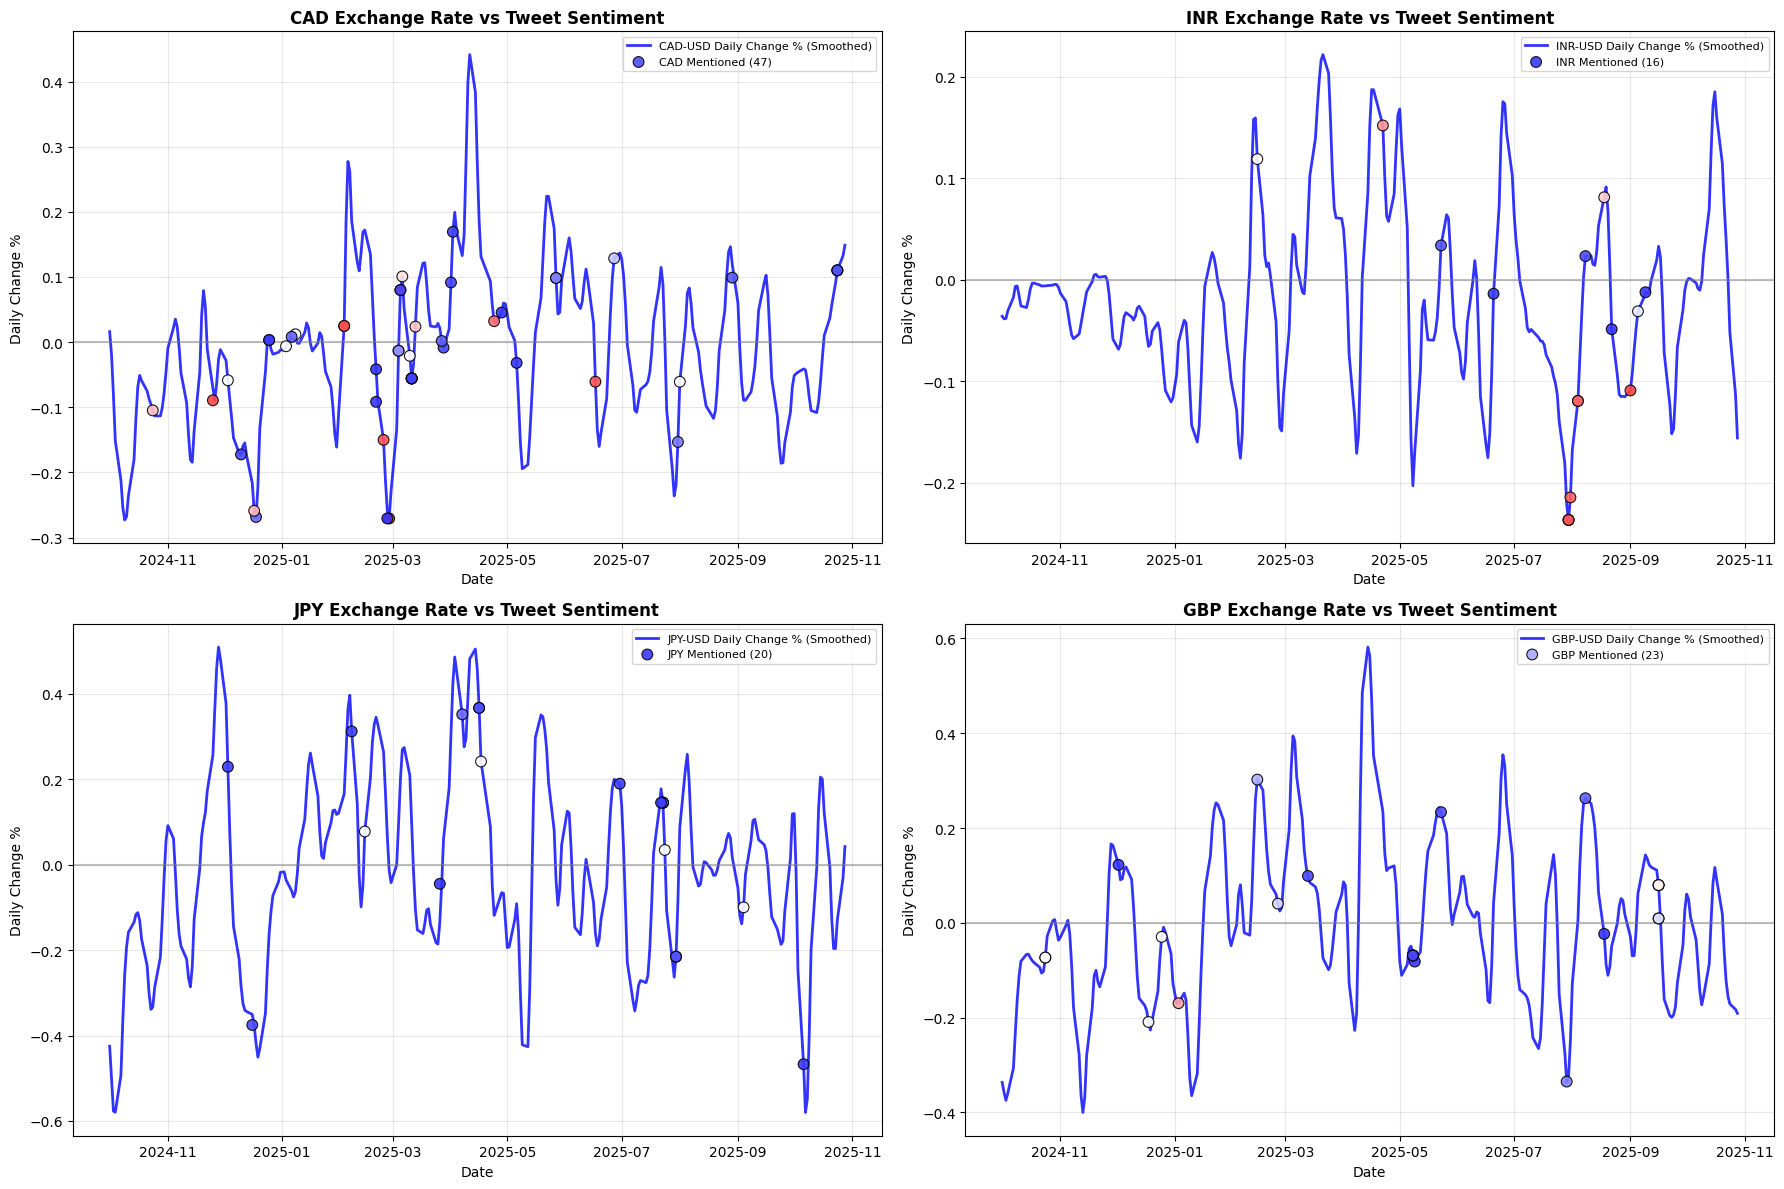

✓ 4-currency correlation visualization complete


In [ ]:
# Create the 4-currency comparison plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 10))

print("Building correlation graphs for 4 major currencies...")

# Create plots for major currencies
create_currency_plot('CAD', 'Canadian Dollar', ax1)
create_currency_plot('INR', 'Indian Rupee', ax2)
create_currency_plot('JPY', 'Japanese Yen', ax3)
create_currency_plot('GBP', 'British Pound', ax4)

plt.tight_layout()
plt.show()

print("✓ 4-currency correlation visualization complete")

## 6. Customize Graph Appearance - Sentiment Legend

Create a sentiment color legend to help interpret the color-coded sentiment dots.

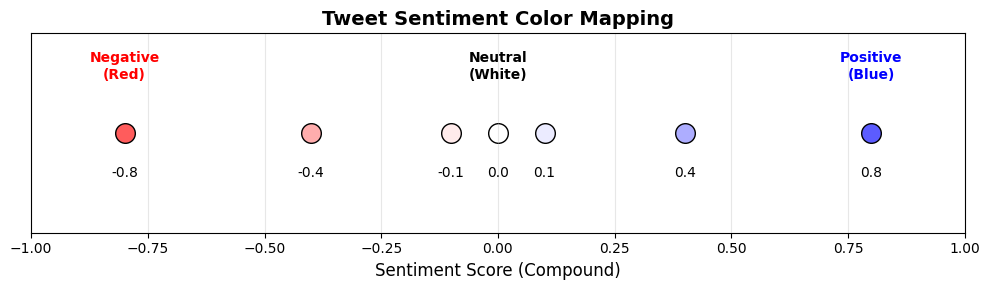

✓ Sentiment legend created


In [32]:
# Create sentiment legend
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# Sample sentiment values for legend
sentiment_samples = [-0.8, -0.4, -0.1, 0.0, 0.1, 0.4, 0.8]
colors_legend = []

for sentiment in sentiment_samples:
    if sentiment < -0.05:
        intensity = abs(sentiment) / 1.0
        colors_legend.append((1.0, 1.0 - intensity * 0.8, 1.0 - intensity * 0.8))
    elif sentiment > 0.05:
        intensity = sentiment / 1.0
        colors_legend.append((1.0 - intensity * 0.8, 1.0 - intensity * 0.8, 1.0))
    else:
        colors_legend.append((1.0, 1.0, 1.0))

# Plot sentiment color scale
for i, (sentiment, color) in enumerate(zip(sentiment_samples, colors_legend)):
    ax.scatter(sentiment, 0, c=[color], s=200, edgecolors='black', linewidth=1)
    ax.text(sentiment, -0.1, f'{sentiment:.1f}', ha='center', va='top', fontsize=10)

ax.set_xlim(-1, 1)
ax.set_ylim(-0.3, 0.3)
ax.set_xlabel('Sentiment Score (Compound)', fontsize=12)
ax.set_title('Tweet Sentiment Color Mapping', fontsize=14, fontweight='bold')
ax.text(-0.8, 0.2, 'Negative\n(Red)', ha='center', va='center', fontweight='bold', color='red')
ax.text(0, 0.2, 'Neutral\n(White)', ha='center', va='center', fontweight='bold')
ax.text(0.8, 0.2, 'Positive\n(Blue)', ha='center', va='center', fontweight='bold', color='blue')
ax.set_yticks([])
ax.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Sentiment legend created")

## 7. Save Graphs to Files

Export the correlation visualizations to various file formats for presentations and reports.

Saving correlation graphs to files...
Saving individual currency graphs...
✓ CAD graph saved as:
  - correlation_graphs/cad_correlation_graph.png
✓ INR graph saved as:
  - correlation_graphs/inr_correlation_graph.png
✓ JPY graph saved as:
  - correlation_graphs/jpy_correlation_graph.png
✓ INR graph saved as:
  - correlation_graphs/inr_correlation_graph.png
✓ JPY graph saved as:
  - correlation_graphs/jpy_correlation_graph.png
✓ GBP graph saved as:
  - correlation_graphs/gbp_correlation_graph.png

Saving combined correlation graph...
✓ GBP graph saved as:
  - correlation_graphs/gbp_correlation_graph.png

Saving combined correlation graph...
✓ Combined graph saved as:
  - correlation_graphs/currency_correlation_graphs_combined.png
✓ Combined graph saved as:
  - correlation_graphs/currency_correlation_graphs_combined.png


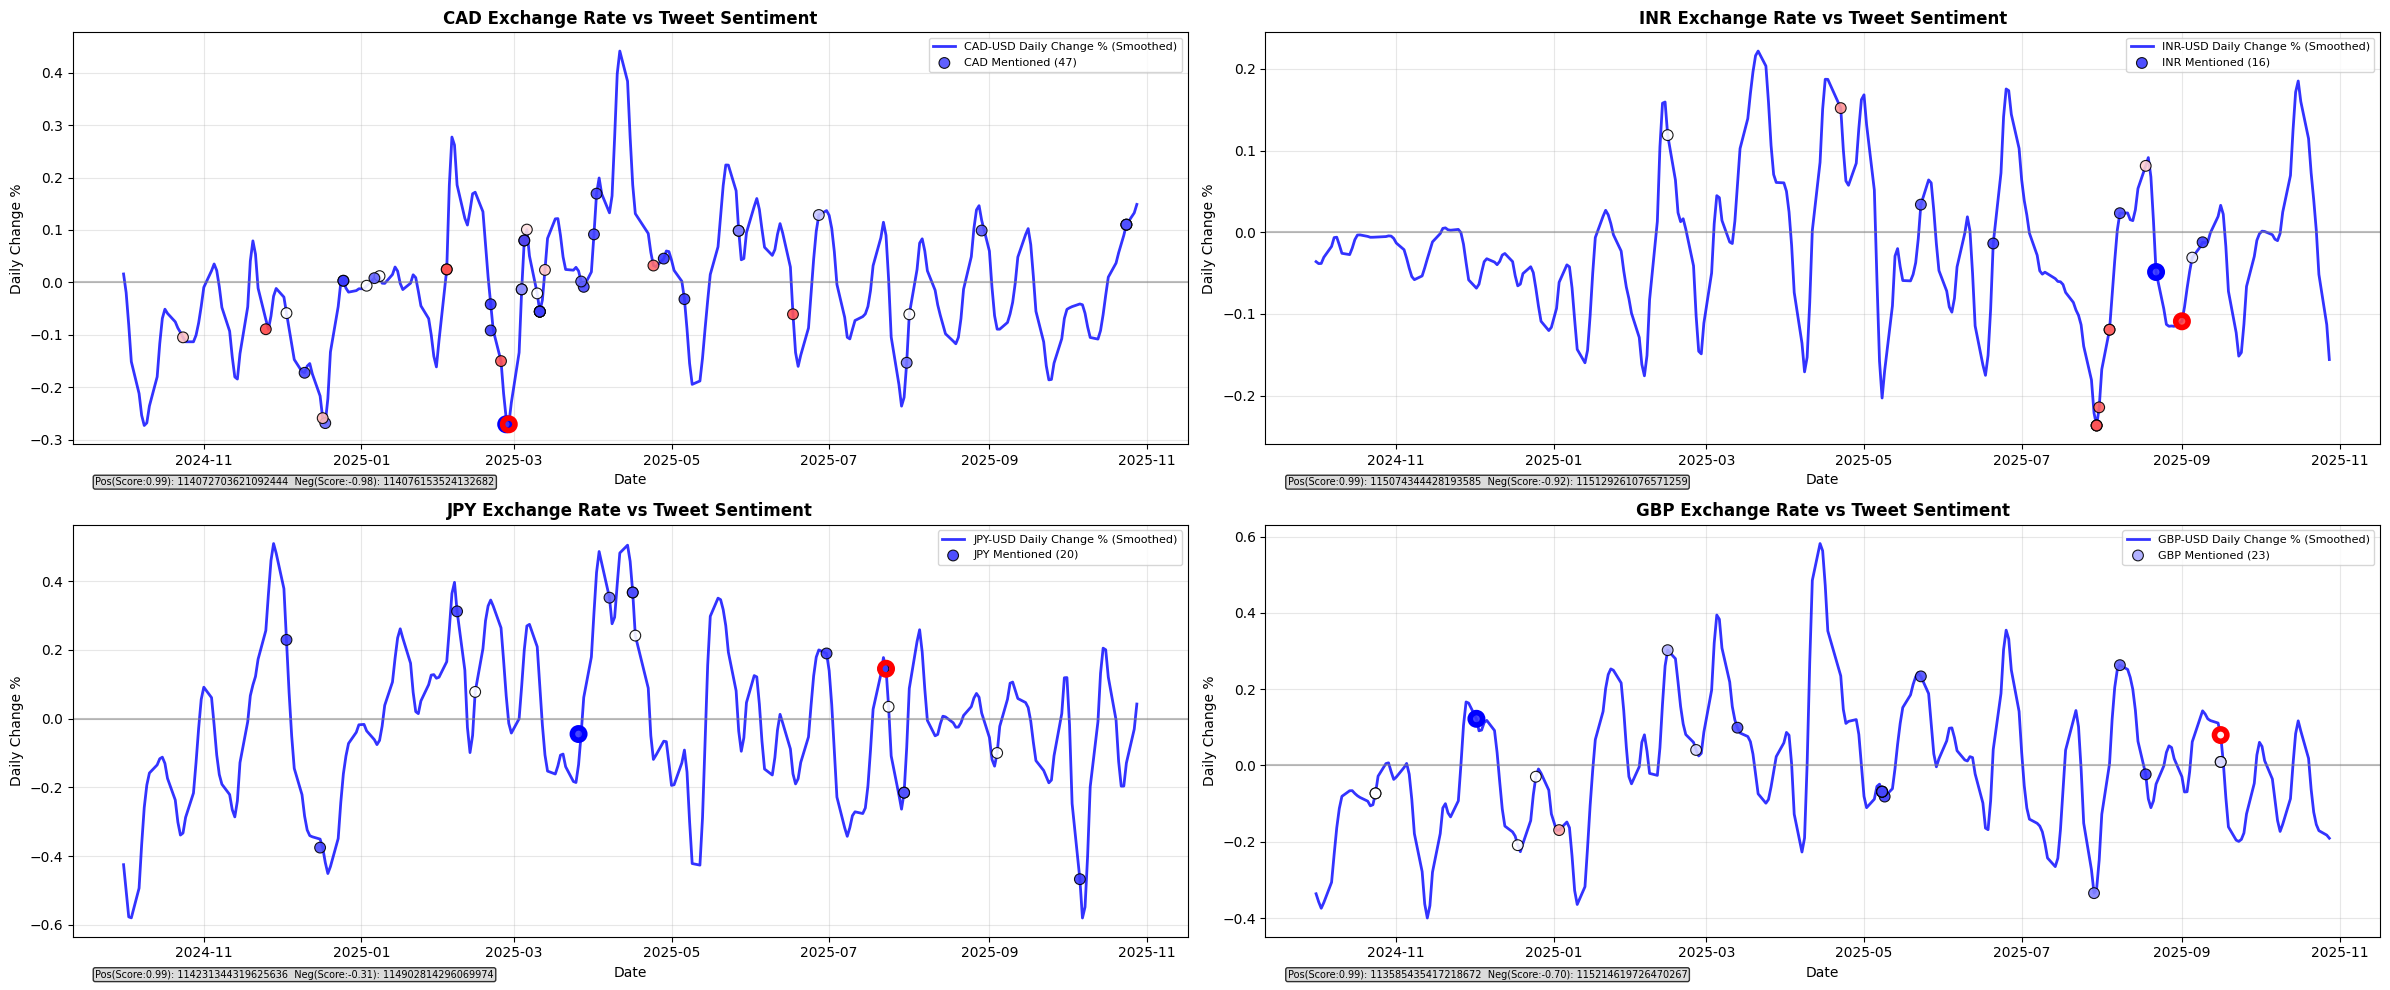

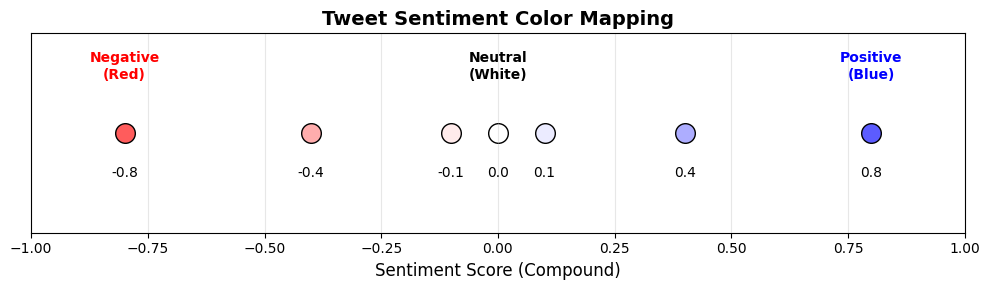

✓ Sentiment legend saved as correlation_graphs/sentiment_legend.png

=== Visualization Export Complete ===
Individual currency graphs saved:
  - correlation_graphs/cad_correlation_graph.png
  - correlation_graphs/inr_correlation_graph.png
  - correlation_graphs/jpy_correlation_graph.png
  - correlation_graphs/gbp_correlation_graph.png
Combined graph saved:
  - correlation_graphs/currency_correlation_graphs_combined.png
Legend saved:
  - correlation_graphs/sentiment_legend.png

All graphs have been generated and saved as PNG files in the correlation_graphs folder.


In [57]:
# Save the main correlation graphs
print("Saving correlation graphs to files...")

# First, save individual currency graphs
currencies = [
    ('CAD', 'Canadian Dollar'),
    ('INR', 'Indian Rupee'),
    ('JPY', 'Japanese Yen'),
    ('GBP', 'British Pound')
]

print("Saving individual currency graphs...")
for currency_code, currency_name in currencies:
    # Create individual figure for each currency (wide format for PowerPoint)
    fig, ax = plt.subplots(1, 1, figsize=(16, 6))

    # Create the plot for this currency
    create_currency_plot(currency_code, currency_name, ax)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)  # Reduced space for compact tweet ID info

    # Save in PNG format only
    filename_base = f'correlation_graphs/{currency_code.lower()}_correlation_graph'
    plt.savefig(f'{filename_base}.png', dpi=300, bbox_inches='tight')

    print(f"✓ {currency_code} graph saved as:")
    print(f"  - {filename_base}.png")
    plt.close()  # Close the figure to free memory

# Now create and save the combined 4-currency graph
print("\nSaving combined correlation graph...")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 10))

# Create plots for major currencies
create_currency_plot('CAD', 'Canadian Dollar', ax1)
create_currency_plot('INR', 'Indian Rupee', ax2)
create_currency_plot('JPY', 'Japanese Yen', ax3)
create_currency_plot('GBP', 'British Pound', ax4)

plt.tight_layout()

# Save in PNG format only
plt.savefig('correlation_graphs/currency_correlation_graphs_combined.png', dpi=300, bbox_inches='tight')

print("✓ Combined graph saved as:")
print("  - correlation_graphs/currency_correlation_graphs_combined.png")

plt.show()

# Save the sentiment legend separately
fig_legend, ax_legend = plt.subplots(1, 1, figsize=(10, 3))

sentiment_samples = [-0.8, -0.4, -0.1, 0.0, 0.1, 0.4, 0.8]
colors_legend = []

for sentiment in sentiment_samples:
    if sentiment < -0.05:
        intensity = abs(sentiment) / 1.0
        colors_legend.append((1.0, 1.0 - intensity * 0.8, 1.0 - intensity * 0.8))
    elif sentiment > 0.05:
        intensity = sentiment / 1.0
        colors_legend.append((1.0 - intensity * 0.8, 1.0 - intensity * 0.8, 1.0))
    else:
        colors_legend.append((1.0, 1.0, 1.0))

for i, (sentiment, color) in enumerate(zip(sentiment_samples, colors_legend)):
    ax_legend.scatter(sentiment, 0, c=[color], s=200, edgecolors='black', linewidth=1)
    ax_legend.text(sentiment, -0.1, f'{sentiment:.1f}', ha='center', va='top', fontsize=10)

ax_legend.set_xlim(-1, 1)
ax_legend.set_ylim(-0.3, 0.3)
ax_legend.set_xlabel('Sentiment Score (Compound)', fontsize=12)
ax_legend.set_title('Tweet Sentiment Color Mapping', fontsize=14, fontweight='bold')
ax_legend.text(-0.8, 0.2, 'Negative\n(Red)', ha='center', va='center', fontweight='bold', color='red')
ax_legend.text(0, 0.2, 'Neutral\n(White)', ha='center', va='center', fontweight='bold')
ax_legend.text(0.8, 0.2, 'Positive\n(Blue)', ha='center', va='center', fontweight='bold', color='blue')
ax_legend.set_yticks([])
ax_legend.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('correlation_graphs/sentiment_legend.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Sentiment legend saved as correlation_graphs/sentiment_legend.png")
print("\n=== Visualization Export Complete ===")
print("Individual currency graphs saved:")
print("  - correlation_graphs/cad_correlation_graph.png")
print("  - correlation_graphs/inr_correlation_graph.png")
print("  - correlation_graphs/jpy_correlation_graph.png")
print("  - correlation_graphs/gbp_correlation_graph.png")
print("Combined graph saved:")
print("  - correlation_graphs/currency_correlation_graphs_combined.png")
print("Legend saved:")
print("  - correlation_graphs/sentiment_legend.png")
print("\nAll graphs have been generated and saved as PNG files in the correlation_graphs folder.")

## 8. Extract Image URLs for Extreme Sentiment Tweets

Display the image URLs for the most positive and negative sentiment tweets for each currency to enable further analysis.

In [58]:
# Extract image URLs for tweets with extreme sentiment for each currency
print("=== EXTREME SENTIMENT TWEET IMAGE URLs ===\n")

currencies = [
    ('CAD', 'Canadian Dollar'),
    ('INR', 'Indian Rupee'),
    ('JPY', 'Japanese Yen'),
    ('GBP', 'British Pound')
]

for currency_code, currency_name in currencies:
    print(f"🔸 {currency_name} ({currency_code}):")
    print("=" * 50)

    # Get tweets mentioning this currency using the currencies_found column
    if currency_column == 'currencies_found':
        # currencies_found is a list format
        currency_tweets = df[df[currency_column].apply(
            lambda currencies: currencies and currency_code in currencies if currencies else False
        )].copy()
    else:
        # currency_codes is a string format
        currency_tweets = df[df[currency_column].str.contains(currency_code, na=False, case=False)].copy()

    if len(currency_tweets) == 0:
        print(f"   No tweets found mentioning {currency_code}\n")
        continue

    # Find most positive and negative tweets
    sentiments = currency_tweets['sentiment_compound'].values

    if len(sentiments) > 0:
        most_positive_idx = currency_tweets['sentiment_compound'].idxmax()
        most_negative_idx = currency_tweets['sentiment_compound'].idxmin()

        pos_tweet = currency_tweets.loc[most_positive_idx]
        neg_tweet = currency_tweets.loc[most_negative_idx]

        # Display most positive tweet info
        if pos_tweet['sentiment_compound'] > 0.05:
            print(f"📈 MOST POSITIVE (Score: {pos_tweet['sentiment_compound']:.3f}):")
            print(f"   Tweet ID: {pos_tweet['id']}")
            print(f"   Date: {pos_tweet['date']}")
            print(f"   Text: {pos_tweet['text'][:100]}...")
            if 'image_url' in pos_tweet and pd.notna(pos_tweet['image_url']) and pos_tweet['image_url'].strip():
                print(f"   📸 Image URL: {pos_tweet['image_url']}")
            else:
                print(f"   📸 Image URL: No image available")
            print()

        # Display most negative tweet info
        if neg_tweet['sentiment_compound'] < -0.05:
            print(f"📉 MOST NEGATIVE (Score: {neg_tweet['sentiment_compound']:.3f}):")
            print(f"   Tweet ID: {neg_tweet['id']}")
            print(f"   Date: {neg_tweet['date']}")
            print(f"   Text: {neg_tweet['text'][:100]}...")
            if 'image_url' in neg_tweet and pd.notna(neg_tweet['image_url']) and neg_tweet['image_url'].strip():
                print(f"   📸 Image URL: {neg_tweet['image_url']}")
            else:
                print(f"   📸 Image URL: No image available")
            print()

        if pos_tweet['sentiment_compound'] <= 0.05 and neg_tweet['sentiment_compound'] >= -0.05:
            print(f"   No strongly positive or negative tweets found for {currency_code}")
            print()

    print("-" * 50)
    print()

print("✓ Extreme sentiment tweet analysis complete!")

=== EXTREME SENTIMENT TWEET IMAGE URLs ===

🔸 Canadian Dollar (CAD):
📈 MOST POSITIVE (Score: 0.995):
   Tweet ID: 114072703621092444
   Date: 2025-02-26 23:08:42+00:00
   Text: Wayne Gretzky is a fantastic guy! They call him, “The Great One,” and he is. He could run for any po...
   📸 Image URL: https://media-cdn.factba.se/realdonaldtrump-truthsocial/114072703621092444.jpg

📉 MOST NEGATIVE (Score: -0.982):
   Tweet ID: 114076153524132682
   Date: 2025-02-27 13:46:03+00:00
   Text: Drugs are still pouring into our Country from Mexico and Canada at very high and unacceptable levels...
   📸 Image URL: https://media-cdn.factba.se/realdonaldtrump-truthsocial/114076153524132682.jpg

--------------------------------------------------

🔸 Indian Rupee (INR):
📈 MOST POSITIVE (Score: 0.993):
   Tweet ID: 115074344428193585
   Date: 2025-08-22 20:39:08+00:00
   Text: I am pleased to announce that I am promoting Sergio Gor to be our next United States Ambassador to t...
   📸 Image URL: https://medi